In [75]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from scipy.ndimage import distance_transform_edt

In [76]:
base_path = "/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE/training"
image_path = os.path.join(base_path, "images")
gt_path = os.path.join(base_path, "1st_manual")
mask_path = os.path.join(base_path, "mask")

In [77]:
def extract_thin_vessels(gt_mask):
    thin_thr = 2 
    dist = distance_transform_edt(gt_mask) 
    thin = ((gt_mask == 1) & (dist <= thin_thr)).astype(np.uint8)
    return thin

def get_sensitivity(pred, gt):
    tp = np.sum((pred == 1) & (gt == 1))
    fn = np.sum((pred == 0) & (gt == 1))
    return tp / (tp + fn )

In [78]:

sens_niblack_list = []
sens_sauvola_list = []

for file in sorted(os.listdir(image_path)):
    if file.endswith(".tif"):
        img_id = file.split("_")[0]
        img = cv2.imread(os.path.join(image_path, file))
        gt = cv2.imread(os.path.join(gt_path, f"{img_id}_manual1.gif"), 0)
        mask = cv2.imread(os.path.join(mask_path, f"{img_id}_training_mask.gif"), 0)

        green = cv2.equalizeHist(img[:, :, 1])
        fov_bin = (mask > 0).astype(np.uint8)
        gt_bin = (gt > 0).astype(np.uint8)

      
        gt_thin = extract_thin_vessels(gt_bin) * fov_bin

   
        th_n = threshold_niblack(green, window_size=25, k=-0.2)
        bin_n = (green < th_n).astype(np.uint8) * fov_bin

   
        th_s = threshold_sauvola(green, window_size=35, k=0.2)
        bin_s = (green < th_s).astype(np.uint8) * fov_bin

        sens_niblack_list.append(get_sensitivity(bin_n, gt_thin))
        sens_sauvola_list.append(get_sensitivity(bin_s, gt_thin))

In [79]:
import pandas as pd

df = pd.DataFrame({
    "Image": range(1, len(sens_niblack_list)+1),
    "Niblack": sens_niblack_list,
    "Sauvola": sens_sauvola_list
})

print(df)

    Image   Niblack   Sauvola
0       1  0.865743  0.559020
1       2  0.862817  0.442847
2       3  0.881478  0.440768
3       4  0.859011  0.593428
4       5  0.796403  0.483516
5       6  0.842714  0.652521
6       7  0.843778  0.521893
7       8  0.843660  0.469593
8       9  0.848086  0.425350
9      10  0.832208  0.603953
10     11  0.866671  0.514626
11     12  0.886299  0.571757
12     13  0.879708  0.595017
13     14  0.873395  0.204028
14     15  0.889101  0.427210
15     16  0.889538  0.423844
16     17  0.876632  0.428397
17     18  0.913382  0.590049
18     19  0.892868  0.678011
19     20  0.918113  0.656139


In [80]:
avg_niblack = np.mean(sens_niblack_list)
avg_sauvola = np.mean(sens_sauvola_list)

print("Average Thin Vessel Sensitivity")
print("Niblack :", avg_niblack)
print("Sauvola :", avg_sauvola)


Average Thin Vessel Sensitivity
Niblack : 0.8680800975550508
Sauvola : 0.5140983741270087


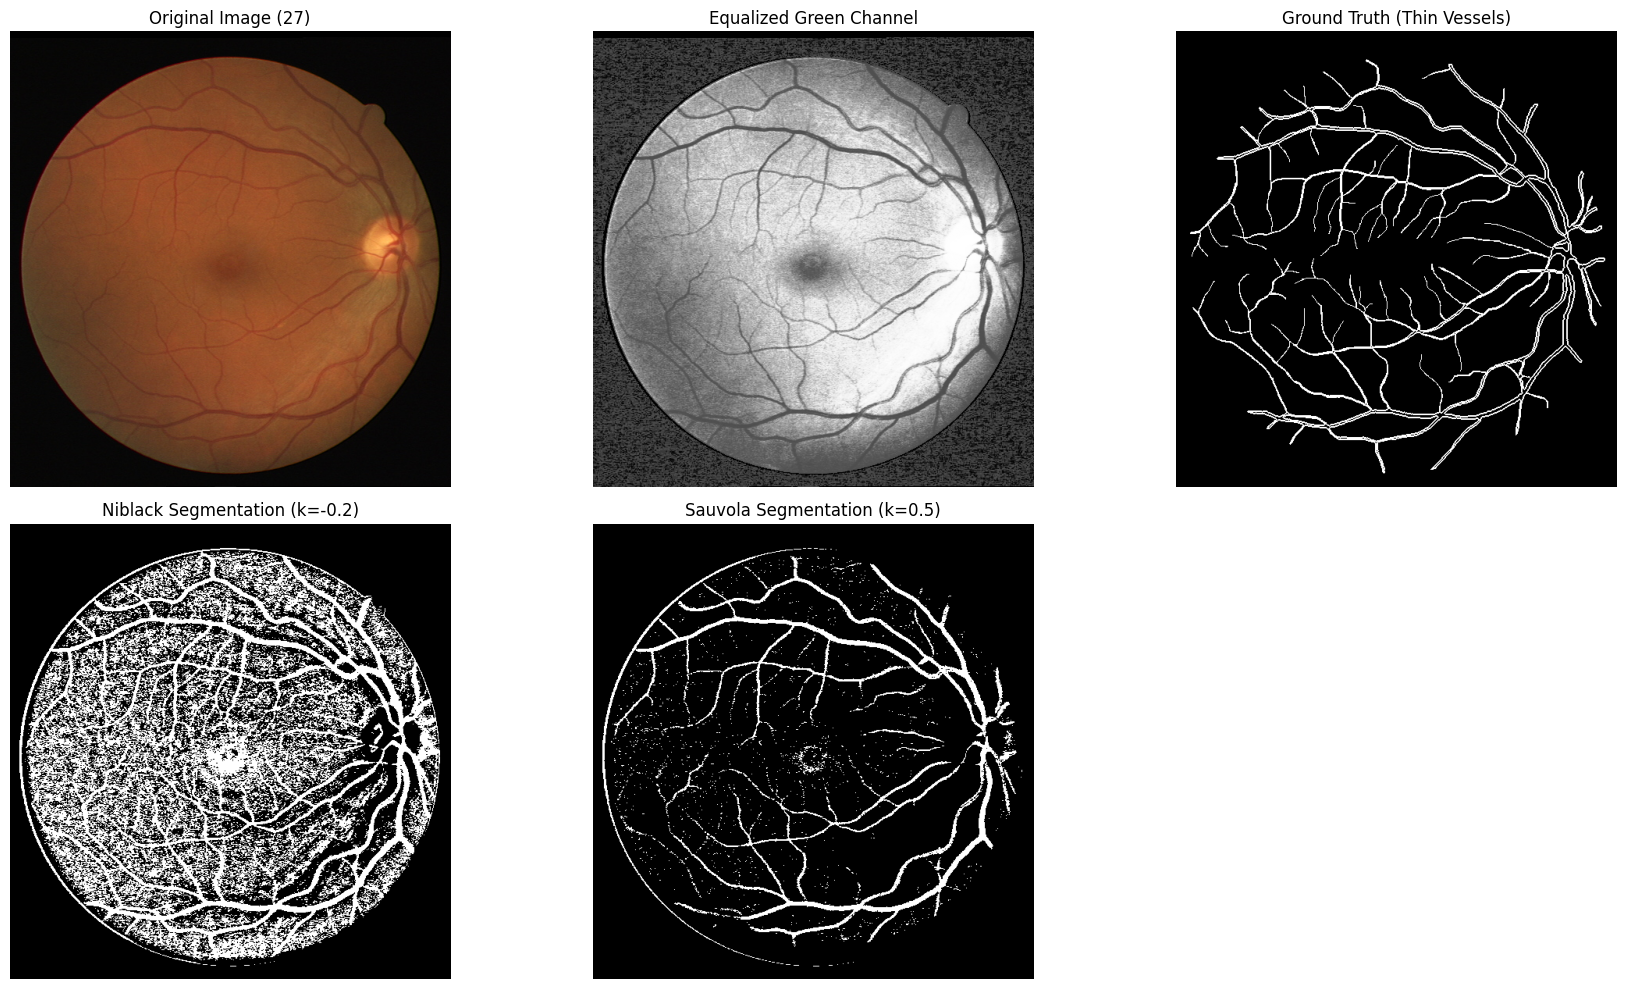

In [ ]:
example_id = "27" 

green = img[:, :, 1]
green_eq = cv2.equalizeHist(green)
fov_mask = (mask > 0)

th_n = threshold_niblack(green_eq, window_size=25, k=-0.2)
bin_n = (green_eq < th_n) * fov_mask

th_s = threshold_sauvola(green_eq, window_size=25, k=0.2)
bin_s = (green_eq < th_s) * fov_mask


gt_bin = (gt > 0).astype(np.uint8)
gt_thin = extract_thin_vessels(gt_bin) * fov_mask

plt.figure(figsize=(18, 10))


plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image ({example_id})")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(green_eq, cmap='gray')
plt.title("Equalized Green Channel")
plt.axis("off")


plt.subplot(2, 3, 3)
plt.imshow(gt_thin, cmap='gray')
plt.title("Ground Truth (Thin Vessels)")
plt.axis("off")


plt.subplot(2, 3, 4)
plt.imshow(bin_n, cmap='gray')
plt.title("Niblack Segmentation (k=-0.2)")
plt.axis("off")


plt.subplot(2, 3, 5)
plt.imshow(bin_s, cmap='gray')
plt.title("Sauvola Segmentation (k=0.5)")
plt.axis("off")


plt.tight_layout()
plt.show()